#### General imports and definitions

In [13]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import class_weight

import matplotlib
import matplotlib.pyplot as plt
plt.rc('font', size=16) 

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

2.6.4
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Suppress warnings

In [14]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Set seed for reproducibility

In [15]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#### Load and clean the dataset

In [16]:
# Load the .npy file
X = np.load(r'../input/training/x_train.npy').astype(np.float16)
y = np.load(r'../input/training/y_train.npy').astype(np.int8)

# Note as sequences are already built, with window 36
print(X.shape, X.dtype, sep=", ")   
print(y.shape, y.dtype, sep=", ") 

(2429, 36, 6), float16
(2429,), int8


#### Visualize data distribution

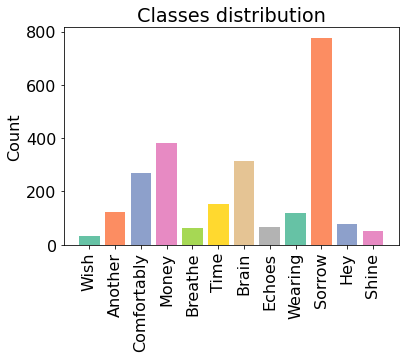

In [17]:
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11,  
}

# Vertical bar plot of the classes distribution in y
plt.title('Classes distribution')
plt.bar(label_mapping.keys(), np.bincount(y), color = matplotlib.colormaps['Set2'].colors)
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

In [18]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=y)
print(X_train.shape)
print(X_test.shape)

# Compute the class weights in order to balance loss during training
labels = np.unique(np.fromiter([t for t in y_train], np.int32))
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_train)))
print(class_weights)

# Convert the sparse labels to categorical values
y = tfk.utils.to_categorical(y)
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
print(y_train.shape)
print(y_test.shape)

(2064, 36, 6)
(365, 36, 6)
{0: 5.931034482758621, 1: 1.638095238095238, 2: 0.7510917030567685, 3: 0.5308641975308642, 4: 3.2452830188679247, 5: 1.323076923076923, 6: 0.6466165413533834, 7: 2.9655172413793105, 8: 1.6862745098039216, 9: 0.2606060606060606, 10: 2.646153846153846, 11: 4.0}
(2064, 12)
(365, 12)


#### Metadata

In [19]:
input_shape = X_train.shape[1:]
n_timestamps, n_features = input_shape
classes = y_train.shape[-1]
batch_size = 512
epochs = 200

# Define the K-fold Cross Validator
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True)

#### Data scaling

In [20]:
scaling = False

if scaling:
    n_instances_train = X_train.shape[0]
    n_instances_test = X_test.shape[0]
    X_train = np.reshape(X_train, newshape=(-1, n_features))
    X_test = np.reshape(X_test, newshape=(-1, n_features))
    print(X_train.shape, X_test.shape, sep=', ')
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train = np.reshape(X_train, newshape=(n_instances_train, n_timestamps, n_features))
    X_test = np.reshape(X_test, newshape=(n_instances_test, n_timestamps, n_features))

#### Data reshaping

In [21]:
reshaping = False

if reshaping:
    # reshape data into time steps of sub-sequences
    n_steps, n_length = 6, 6
    assert n_steps * n_length == n_timestamps
    X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
    X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))
    input_shape = X_train.shape[1:]

#### Support functions

In [22]:
def plot_history(history):
    best_epoch = np.argmax(history['val_accuracy'])
    plt.figure(figsize=(17,4))
    plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Categorical Crossentropy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
    plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

    plt.figure(figsize=(17,4))
    plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
    plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
    plt.legend()
    plt.grid(alpha=.3)
    plt.show()

def plot_cm(model):
    # Predict the test set with the LSTM
    predictions = model.predict(X_test)
    predictions.shape

    # Compute the confusion matrix
    cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

    # Compute the classification metrics
    accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
    precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
    f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average=None)
    print('Accuracy:',accuracy.round(4))
    print('Precision:',precision.round(4))
    print('Recall:',recall.round(4))
    print('F1:',f1.round(4))

    # Plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()), annot=True, fmt="d")
    plt.xlabel('True labels')
    plt.ylabel('Predicted labels')
    plt.show()

#### Classifier

In [23]:
# we advice to choose what parameters to change and include them directly among the attributes of this function
def build_TS_classifier(input_shape, classes, n_conv, bi, n_dense):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    # Convolutional part
    for i in range(n_conv):
        if i == 0:
            x = tfkl.Conv1D(128,3,padding='same',activation='relu')(input_layer)
        else:
            x = tfkl.Conv1D(128,3,padding='same',activation='relu')(x)
        x = tfkl.MaxPooling1D()(x)
    
    # LSTM module
    if n_conv == 0:
        if bi == 0:
            x = tfkl.LSTM(128, return_sequences=True)(input_layer)
        else:
            x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
    else:
        if bi == 0:
            x = tfkl.LSTM(128, return_sequences=True)(x)
        else:
            x = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(x)
    x = tfkl.Flatten()(x)
    
    # Classifier
    x = tfkl.Dropout(0.5)(x)
    for i in range(n_dense):
        x = tfkl.Dense(256, activation='relu')(x)
    output_layer = tfkl.Dense(classes, activation='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='cnn_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(2e-3), metrics='accuracy')

    # Return the model
    return model

Epoch 1/200
5/5 [==============================] - 4s 181ms/step - loss: 2.2308 - accuracy: 0.2582 - val_loss: 1.8610 - val_accuracy: 0.4027
Epoch 2/200
5/5 [==============================] - 0s 13ms/step - loss: 1.9285 - accuracy: 0.3653 - val_loss: 1.8039 - val_accuracy: 0.3726
Epoch 3/200
5/5 [==============================] - 0s 14ms/step - loss: 1.8639 - accuracy: 0.3818 - val_loss: 1.7302 - val_accuracy: 0.3781
Epoch 4/200
5/5 [==============================] - 0s 13ms/step - loss: 1.7889 - accuracy: 0.4026 - val_loss: 1.7691 - val_accuracy: 0.3863
Epoch 5/200
5/5 [==============================] - 0s 13ms/step - loss: 1.8090 - accuracy: 0.3886 - val_loss: 1.5768 - val_accuracy: 0.4356
Epoch 6/200
5/5 [==============================] - 0s 13ms/step - loss: 1.6881 - accuracy: 0.4249 - val_loss: 1.5565 - val_accuracy: 0.4603
Epoch 7/200
5/5 [==============================] - 0s 13ms/step - loss: 1.6536 - accuracy: 0.4385 - val_loss: 1.4882 - val_accuracy: 0.5014
Epoch 8/200
5/5 [==

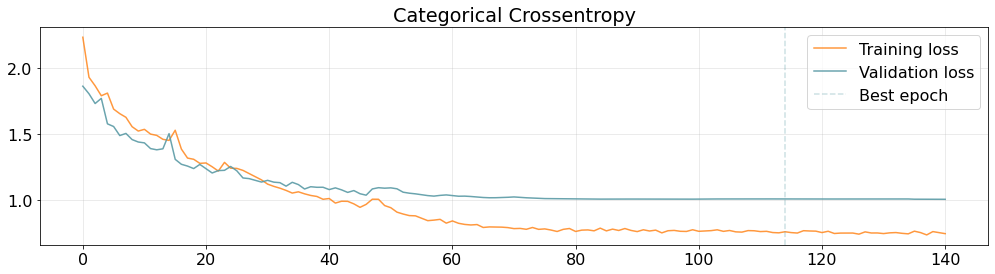

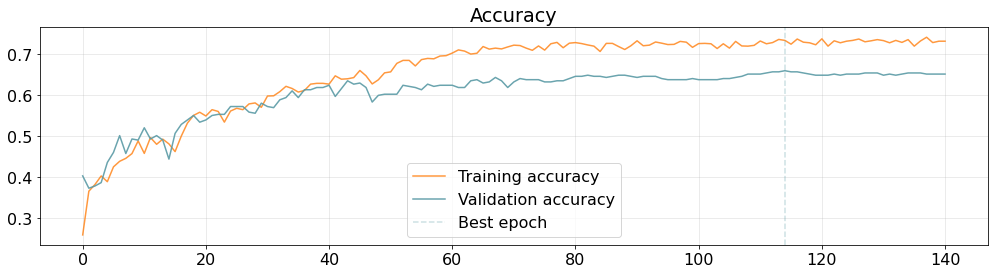

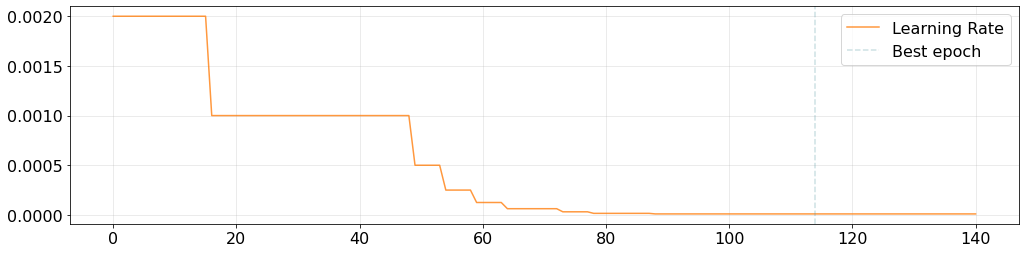

Accuracy: 0.6603
Precision: 0.4611
Recall: 0.4335
F1: [0.     0.5517 0.8723 0.4118 0.     0.4375 0.8485 0.     0.85   0.7158
 0.     0.4615]


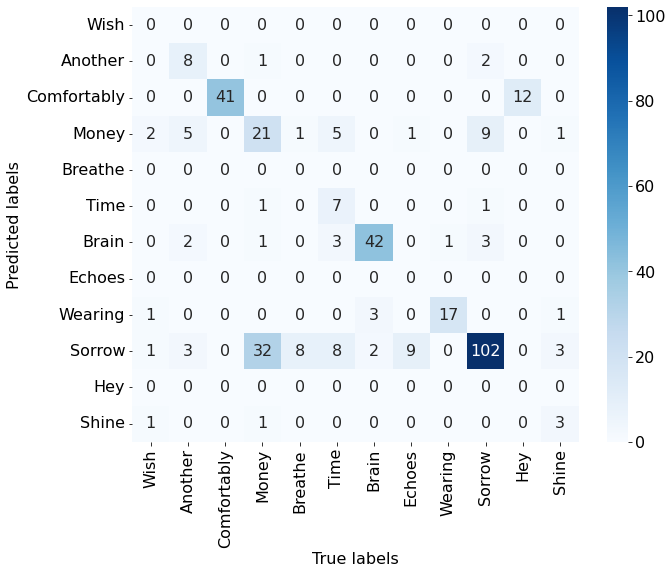

In [24]:
cross_val = False

if cross_val:
    # K-fold Cross Validation model evaluation
    best_acc = 0
    best_model = None
    best_history =  []
    
    i = 0
    for n_conv in [0, 1, 2, 3]:
        for bi in [0, 1]:
            for n_dense in [0, 1, 2]:
                i += 1
                print(f'°°°°°°°°°°°°°°°°°°°°°°°°°°°°° MODEL {i} °°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°')

                acc_per_fold = []
                loss_per_fold = []
                fold_no = 1
                for train, test in kfold.split(X, y):

                    # Define the model architecture
                    model = build_TS_classifier(input_shape, classes, n_conv, bi, n_dense)

                    # Generate a print
                    print(f'Training for fold {fold_no} ...')

                    # Fit data to model
                    history = model.fit(X[train], y[train],
                              batch_size = batch_size,
                              epochs = epochs,
                              validation_data = (X[test], y[test]),
                              #class_weight = class_weights,
                              verbose=0,
                              callbacks = [
                                  tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=26, restore_best_weights=True),
                                  tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
                              ]
                    ).history

                    # Generate generalization metrics
                    scores = model.evaluate(X[test], y[test], verbose=0)
                    print(f'\nScore for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
                    acc_per_fold.append(scores[1] * 100)
                    loss_per_fold.append(scores[0])

                    # Increase fold number
                    fold_no = fold_no + 1
                    if fold_no <= num_folds + 1:
                        print('------------------------------------------------------------------------')

                print('\nAverage scores for all folds:')
                acc = np.mean(acc_per_fold)
                print(f'> Accuracy: {acc} (+- {np.std(acc_per_fold)})')
                print(f'> Loss: {np.mean(loss_per_fold)}')
                if acc > best_acc:
                    best_acc = acc
                    best_model = model
                    best_history = history
                print('°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°')
    # RETRAIN THE BEST MODEL ON THE WHOLE DATASET
    best_model.fit(
        x = X,
        y = y,
        batch_size = batch_size,
        epochs = epochs,
        #class_weight = class_weights,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='accuracy', mode='max', patience=26, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
        ]
    )
    
else:
    best_model = build_TS_classifier(input_shape, classes, 3, 1, 1)
    
    # Train the model
    best_history = best_model.fit(
        x = X_train,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_data = (X_test, y_test),
        #class_weight = class_weights,
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=26, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
        ]
    ).history

# Plot results
best_model.summary()
plot_history(best_history)
plot_cm(best_model)